## Анатомия нейронных сетей на PyTorch на примере полносвязной нейронной сети  

**Нейронная сеть** -- математическая модель, а также ее программные и аппаратные реализации, предназначенные для поиска неких полезных представлений данных в пространстве представлений.

Как уже известно, нейронные сети состоят из следующих компонентов:
* **Данные** -- входные и выходные (а иногда только входные)  
* **Модель** нейронной сети, состоящая из **слоев**  
* **Весовые параметры** -- те параметры, которые непосредственно изменяются в процессе обучения  
* **Функция потерь** -- определяет, каким образом будут обновляться весовые параметры сети для достижения желаемых результатов  
* **Оптимизатор** -- непосредственно отвечает за обновление весовых коэффицинтов сети.  

Процесс обновления весовых параметров нейронной сети, при котором ошибка сети, характерищующаяся функцией потерь, стремится к минимуму, называется **обучением сети**  

Нагляднее всего процесс обучения представить в виде картинки ниже:  

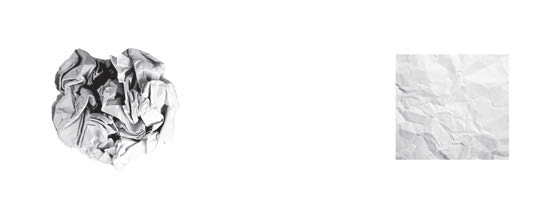


Пусть необходимо решить задачу классификации листов бумаги по цвету нейронной сетью. Пусть скомканные листы бумаги являются входными данными, а каждый лист бумаги принадлежит тому или иному классу цвета.  
Тогда суть ее работы сводится к постепенному преобразованию этого комка таким образом, чтобы классы стали явно различимыми.

Самый простой тип нейронных сетей, с которыми можно работать в рамках PyTorch -- полносвязные нейронные сети  

Рассмотрим основные этапы построения нейронной сети в PyTorch на примере полносвязной сети, которая будет решать задачу классификации изображений на примере датасета Fashion-MNIST

### 1. Получение данных. Создание загрузчика данных  

Доступ к набору данных Fashion-MNIST можно получить непосредственно из PyTorch с помощью модуля `torchvision.datasets`. Данный модуль содержит реализации популярных датасетов. например, MNIST, CIFAR10 и т. д.  

В PyTorch имеется набор инструментов для загрузки и преобразования данных, которые обычно отнимают очень много времени  

PyTorch также предоставляет возможность создавать кастомные датасеты (об этом поговорим в следующем занятии)



Перед построением нейронной сети зададим генераторы случайных чисел для того, чтобы результаты обучения были воспроизводимыми

In [3]:
import numpy as np
import torch
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Загрузим тренировочные и тестовые выборки датасета Fashion-MNIST  

In [4]:
import torchvision.datasets as dataset

train_data = dataset.FashionMNIST(r"content\Fashion-MNIST", train=True, download=True)
test_data = dataset.FashionMNIST(r"content\Fashion-MNIST", train=False, download=True)

Extracting content\Fashion-MNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to content\Fashion-MNIST\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting content\Fashion-MNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to content\Fashion-MNIST\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting content\Fashion-MNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to content\Fashion-MNIST\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting content\Fashion-MNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to content\Fashion-MNIST\FashionMNIST\raw



Перед тем как создать объекты датасетов, которые будут непосредственно участвовать в обучении, следует остановиться на механизме аугментации  

**Аугментация** (расширение) -- механизм, позволяющий за счет некоторых преобразований (в случае с картинками это, например, повороты, флипы, ресайз и т. д.) увеличить в объеме наборы данных  

Все необходимые методы для преобразования картинок хранятся в модуле `torchvision.transforms`  

In [5]:
# создадим объекты трансформации,
# отдельные для тренировочного и тестового датасета
# и также сами датасеты

# испортируем модуль transforms
import torchvision.transforms as transform

# вычислим мреднее и стандартное отклонение у тренировочной выборки
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

# создадим объект для трансформации тренировочных изображений
# компоновать несклько трансформаций воедино позволяет класс Compose, в конструктор которого передается список трансформаций
# для картинок из тренировочной выборки выбраны следующие трансформации: случайный поворот на -5 и +5 градусов,
# случайный поворот по вертикали/горизонтали, нормализация, преобразование в тензор PyTorch
train_transforms = transform.Compose([
                            #transform.RandomRotation(5),
                            #transform.RandomHorizontalFlip(),
                            #transform.RandomVerticalFlip(),
                            transform.ToTensor(),
                            transform.Normalize(mean = [mean], std = [std])
                                      ])

# для картинок из тестовой выборки оставим только нормализацию и преобразование в тензор
test_transforms = transform.Compose([
                           transform.ToTensor(),
                           transform.Normalize(mean = [mean], std = [std])
                                     ])


# учтем транфсормации при загрузке датасета Fashion MNIST
train_data = dataset.FashionMNIST(r"content\Fashion-MNIST", train=True, download=True, transform=train_transforms)
test_data = dataset.FashionMNIST(r"content\Fashion-MNIST", train=False, download=True, transform=test_transforms)

Bag


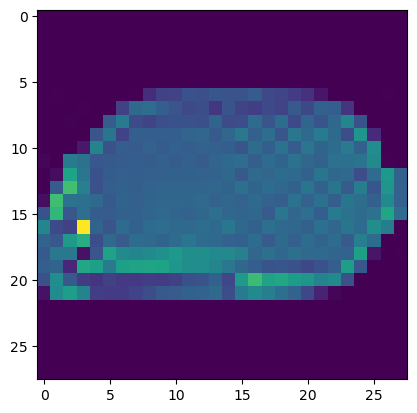

In [6]:
import matplotlib.pyplot as plt

# словарь классов
classes = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boo"
}

# извлечем изображение и метку класса к нему
image, label = train_data[236]

# для "отбрасывания" размерности батча вызываем функцию squeeze()
image_squezze = image.squeeze()

# перевод изображения в NumPy-массив для отображения на графике
image_numpy = image_squezze.numpy()


# вывод изображения
print(classes[label])
plt.imshow(image_numpy, interpolation="nearest")
plt.show()

Для загрузки данных в нейронную сеть необходимо инициализировать **загрузчик**, роль которого по умолчанию играет объект класса **DataLoader**

In [7]:
from torch.utils.data import DataLoader

# создание загрузчика данных для тренировочного набора
train_loader = DataLoader(train_data,
                          batch_size=128,
                          shuffle=True)

# создание загрузчика данных для тестового набора
test_loader = DataLoader(test_data,
                         batch_size=128,
                         shuffle=True)

### 2. Построение полносвязной нейронной сети на PyTorch  

**Полносвязные нейронные сети** являются одними из наиболее простых нейросетевых архитектур для решения задачи классификации изображений.

В полносвязных нейронных сетях каждый нейрон предыдущего слоя связан с каждым нейроном следующего слоя.

Каждая связь имеет **вес**, который определяет ее  силу. Именно эти веса будут обновляться в процессе обучения.

Когда входные данные проходят через сеть, происходит матричное умножение весовых параметров (и смещений) на них. Затем полученные величины поступают в **функцию активации**  
Она вводит элемент нелинейности и непосредственно формирует выходной сигнал слоя.  

Наиболее распространенные функции активации: ReLU, softmax, sigmoid  

Их реализации в случае с PyTorch хранятся в модуле `torch.nn.functional`

In [8]:
import torch.nn.functional as F
print(dir(F))

['BroadcastingList1', 'BroadcastingList2', 'BroadcastingList3', 'Callable', 'DType', 'GRID_SAMPLE_INTERPOLATION_MODES', 'GRID_SAMPLE_PADDING_MODES', 'List', 'Optional', 'TYPE_CHECKING', 'Tensor', 'Tuple', 'Union', '_Reduction', '_VF', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_adaptive_max_pool1d', '_adaptive_max_pool2d', '_adaptive_max_pool3d', '_add_docstr', '_fractional_max_pool2d', '_fractional_max_pool3d', '_get_softmax_dim', '_in_projection', '_in_projection_packed', '_infer_size', '_list_with_default', '_max_pool1d', '_max_pool2d', '_max_pool3d', '_mha_shape_check', '_no_grad_embedding_renorm_', '_overload', '_pair', '_scaled_dot_product_attention', '_single', '_threshold', '_triple', '_unpool_output_size', '_verify_batch_size', '_verify_spatial_size', 'adaptive_avg_pool1d', 'adaptive_avg_pool2d', 'adaptive_avg_pool3d', 'adaptive_max_pool1d', 'adaptive_max_pool1d_with_indices', 'adaptive_max_pool2d', 'adaptive_max_

Далее необходимо **создать класс** нашей нейронной сети, который **обязательно** должен быть унаследован от класса `torch.nn.Module`  
Это базовый класс для всех модулей нейронных сетей в PyTorch  
Затем в нем необходимо определить два метода: `__init__` и `forward`
Метод `__init__` задает последовательность слоев сети  
Метод `forward` определяет, как данные будут передаваться по сети в процессе обучения и прогона)

In [9]:
import torch.nn as nn

# создаем класс, реализующий полносвязную нейронную сеть
class FullyConnectedNeuralNetwork(nn.Module):

  # создаем последовательность слоев сети в конструкторе
  def __init__(self):
    # super() добавляет возможность выполнения функционала
    # родительского класса в классе потомка
    super().__init__()

    # добавляем первый полносвязный слой,
    # который будет иметь 784 входа (28x28x1) и 256 выходов
    self.fc1 = nn.Linear(784, 256)

    # добавляем второй полносвязный слой
    # который будет иметь 256 входов и 256 выходов
    self.fc2 = nn.Linear(256, 512)

    # добавляем третий полносвязный слой,
    # который будет иметь 256 входов и 10 выходов, равных количеству классов в Fashion-MNIST
    self.fc3 = nn.Linear(512, 1024)
    self.fc4 = nn.Linear(1024, 10)

  # реализовываем метод для прямого распространения сигналов по сети
  def forward(self, x):
    # преобразовать в одномерный тензор, т. к. линейные слои
    # не могут работаать с 2D и 3D-данными
    x = x.view(-1, 784)

    # и пропускаем этот вектор через слои,
    # применяя функцию ReLU
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))

    # в последнем слое эту функцию не применяем
    # и возвращаем предсказание
    predict = self.fc4(x)
    return predict


# создадим объект полносвязной сети
fcn = FullyConnectedNeuralNetwork()

# вывод структуры модели в консоль
print(fcn)

FullyConnectedNeuralNetwork(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=10, bias=True)
)


In [10]:
# отобразим количество обучаемых параметров модели

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Модель имеет {count_parameters(fcn)} обучаемых параметров")

Модель имеет 868106 обучаемых параметров


В PyTorch реализовано большое многообразие слоев, которые используются как в известных архитектурах и которых можно использовать для построения своих архитектур.
Все они содержатся в модуле `torch.nn`

In [11]:
print(dir(nn))

['AdaptiveAvgPool1d', 'AdaptiveAvgPool2d', 'AdaptiveAvgPool3d', 'AdaptiveLogSoftmaxWithLoss', 'AdaptiveMaxPool1d', 'AdaptiveMaxPool2d', 'AdaptiveMaxPool3d', 'AlphaDropout', 'AvgPool1d', 'AvgPool2d', 'AvgPool3d', 'BCELoss', 'BCEWithLogitsLoss', 'BatchNorm1d', 'BatchNorm2d', 'BatchNorm3d', 'Bilinear', 'CELU', 'CTCLoss', 'ChannelShuffle', 'ConstantPad1d', 'ConstantPad2d', 'ConstantPad3d', 'Container', 'Conv1d', 'Conv2d', 'Conv3d', 'ConvTranspose1d', 'ConvTranspose2d', 'ConvTranspose3d', 'CosineEmbeddingLoss', 'CosineSimilarity', 'CrossEntropyLoss', 'CrossMapLRN2d', 'DataParallel', 'Dropout', 'Dropout1d', 'Dropout2d', 'Dropout3d', 'ELU', 'Embedding', 'EmbeddingBag', 'FeatureAlphaDropout', 'Flatten', 'Fold', 'FractionalMaxPool2d', 'FractionalMaxPool3d', 'GELU', 'GLU', 'GRU', 'GRUCell', 'GaussianNLLLoss', 'GroupNorm', 'Hardshrink', 'Hardsigmoid', 'Hardswish', 'Hardtanh', 'HingeEmbeddingLoss', 'HuberLoss', 'Identity', 'InstanceNorm1d', 'InstanceNorm2d', 'InstanceNorm3d', 'KLDivLoss', 'L1Loss'

Выше определена простейшая полносвязная нейронная сеть с одним скрытым слоем -- многослойный перцептрон (MLP)

Теперь можно на основе входных данных формировать выходные прогнозы. Для количественного определения того, насколько верные прогнозы выдает сеть, используются **функции потерь**

Реализации функций потерь в PyTorch также содержатся в модуле `torch.nn`

В контексте текущей задачи имеет смысл использовать функцию потерь `CrossEntropyLoss`, также часто используется и `MSELoss`

In [12]:
loss_function = nn.CrossEntropyLoss()


Для выполнения обновления весовых параметров в сети используются **оптимизаторы**. или **функции оптимизации**  

Чаще всего используются функции оптимизации на основе **метода стохастического градиентного спуска (SGD)**.  
Реализация стандартного SGD, а также такие функции оптимизации, как `AdaGrad`, `Adam`, `RMSProp` имеются в модуле `torch.optim`  

В контексте задачи классификации изображений одежды будем использовать оптимизатор `Adam`  
Он принимает два аргумента:
* параметры модели
* коэффициент обучения

In [13]:
import torch.optim as optim
optimizer = optim.Adadelta(fcn.parameters(), lr=0.01)

In [14]:
print(dir(optim))

['ASGD', 'Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'LBFGS', 'NAdam', 'Optimizer', 'RAdam', 'RMSprop', 'Rprop', 'SGD', 'SparseAdam', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_functional', '_multi_tensor', 'lr_scheduler', 'swa_utils']


Все необходимое для запуска обучения готово, теперь можно приступать к реализации цикла обучения  
Кратко процесс обучения нейронной сети можно описать следующим образом:
* на каждой эпохе помещается пакет данных в модель  
* вычситывается потеря, сравнивая предсказания сети с метками пакета данных (прямое распространение)
* рассчитывается градиент для кажлого из параметров сети относительно потерь
* обновляются занчения весовых параметров путем вычитания градиента, умноженного на lr (обратное распространение)

In [15]:
import torch

device = None
# если GPU обнаружен
if torch.cuda.is_available():
  # устанавливаем его в качестве устройства
  device = torch.device("cuda:0")
else: # иначе
  # устанавливаем в качестве устройства СPU
  device = torch.device("cpu")

print(device)

# перемещение модели на устройство
fcn.to(device)
#loss_function.to(device)

cuda:0


FullyConnectedNeuralNetwork(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=10, bias=True)
)

In [16]:
# Заранее определим функцию для расчета точности модели по пакету.
# Она сравнивает индекс самого большого значения прогноза с фактической меткой класса
# Затем количество верных предсказаний делится на общее количество данных в пакете

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Напишем функцию определяющую цикл тренировки по эпохе. Он будет включать в себя следующие шаги:
* перевод модели в режим тренировки
* итерирование по загрузчику тренировочного датасета с возвратом пакетов изображений и меток к ним
* размещение пакетов на GPU, если таковой имеется
* обнуление градиентов предыдущей партии данных
* передача пакета изображений в модель для получения прогнозов
* расчет потери между прогнозами и целевыми метками
* расчет градиентов для каждого обучающего параметра
* обновление весовых параметров

In [17]:
def train(model, train_loader, optimizer, loss_function, device):

    # определяем начяальные значения потерь и точности по эпохе
    epoch_loss = 0
    epoch_acc = 0

    # переводим модель в режим тренировки
    model.train()

    # для каждого батча из тренировочного загрузчика
    for (image, label) in train_loader:

        # достаем изображения и метки к ним
        image = image.to(device)
        label = label.to(device)

        # обнуляем градиенты
        optimizer.zero_grad()

        # получаем прогнозы сети по изображениям
        predict = model(image)

        # вычисляем потери сети
        loss = loss_function(predict, label)

        # вычисляем точность сети на текущем батче
        acc = calculate_accuracy(predict, label)

        # выполняем расчет градиентов на батче
        loss.backward()

        # корректируем веса
        optimizer.step()

        # добавляем значения потерь и точности на батче к общему по эпохе
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # возвращаем потери и точность по эпохе относительно размера тренировочного набора
    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

Напишем функцию оценки модели на эпохе. Она схожа с функцией для тренировки модели. Отличмия заключаются в следующем:
* перевод модели в режим оценки
* оборачивание итерации оценки в `torch.no_grad`
* не происходит обнуления градиентов и обновления весов, т.к. градиенты не вычисляются

In [18]:
def evaluate(model, test_loader, loss_function, device):

    # зададим начальные значения потерь и точности на эпохе на тестовом датасете
    epoch_loss = 0
    epoch_acc = 0

    # переведем модель в режим оценки
    model.eval()

    # не вычисляем градиенты
    with torch.no_grad():

        # для каждого батча в тестовом наборе
        for (image, label) in test_loader:

            # извлекаем изображения и метки
            image = image.to(device)
            label = label.to(device)

            # получаем прогнозы сети
            predict = model(image)

            # вычисляем потери сети
            loss = loss_function(predict, label)

            # вычисляем точность сети на эпохе
            acc = calculate_accuracy(predict, label)

            # добавляем значения потерь и точности на батче к общему по эпохе
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    # возвращаем потери и точность по эпохе относительно размера тестового набора
    return epoch_loss / len(test_loader), epoch_acc / len(test_loader)

In [19]:
# напишем небольшую функцию для измерения времени длительности эпохи
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь все готово к тому, чтобы начать обучение сети  
Напишем код для выполнения полного цикла обучения, который будет включать себя тренировку и оценку сети

In [20]:
import time

# задаем количество эпох
epochs_count = 10

# задаем устройство, на котором будет производиться обучение
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# перемещаем модель на устройство
fcn.to(device)

# зададим начальное значение лучшей потери на тестовом датасете в виде бесконечности
#best_test_loss = float('inf')

# в каждой эпохе
for epoch in range(epochs_count):

    # задаем отсечку начала эпохи
    start_time = time.monotonic()

    # вычисляем потери и точность на тренировочном и тестовом датасетах
    train_loss, train_acc = train(fcn, train_loader, optimizer, loss_function, device)
    test_loss, test_acc = evaluate(fcn, test_loader, loss_function, device)

    # обновляем значениелучшей тестовой потери
    #if test_loss < best_test_loss:
    #    best_valid_loss = valid_loss

    # задаем отсечку конца эпохи
    end_time = time.monotonic()

    # находим количество минут и секунд, потребовавшихся на эпоху
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # логируем
    print(f'Epoch: {epoch+1} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc * 100:.2f}%')

Epoch: 1 | Epoch Time: 0m 16s
	Train Loss: 1.548 | Train Acc: 53.53%
	 Test. Loss: 0.894 |  Test. Acc: 70.48%
Epoch: 2 | Epoch Time: 0m 14s
	Train Loss: 0.735 | Train Acc: 74.64%
	 Test. Loss: 0.663 |  Test. Acc: 75.92%
Epoch: 3 | Epoch Time: 0m 13s
	Train Loss: 0.600 | Train Acc: 78.32%
	 Test. Loss: 0.580 |  Test. Acc: 79.01%
Epoch: 4 | Epoch Time: 0m 14s
	Train Loss: 0.539 | Train Acc: 80.70%
	 Test. Loss: 0.540 |  Test. Acc: 80.40%
Epoch: 5 | Epoch Time: 0m 13s
	Train Loss: 0.500 | Train Acc: 82.23%
	 Test. Loss: 0.522 |  Test. Acc: 81.16%
Epoch: 6 | Epoch Time: 0m 14s
	Train Loss: 0.473 | Train Acc: 83.11%
	 Test. Loss: 0.490 |  Test. Acc: 82.34%
Epoch: 7 | Epoch Time: 0m 14s
	Train Loss: 0.453 | Train Acc: 83.85%
	 Test. Loss: 0.484 |  Test. Acc: 82.64%
Epoch: 8 | Epoch Time: 0m 14s
	Train Loss: 0.437 | Train Acc: 84.45%
	 Test. Loss: 0.464 |  Test. Acc: 83.20%
Epoch: 9 | Epoch Time: 0m 14s
	Train Loss: 0.425 | Train Acc: 84.87%
	 Test. Loss: 0.458 |  Test. Acc: 83.75%
Epoch: 10 

Если по поизводительность и точность модели устраивают (или необходимо приостановить работу), то можно сохранить обученную модель на диск  

В PyTorch имеется "из коробки" возможность сохранения моделей, причем несколькими способами  

Первый способ заключается в сохранении текущего состояния модели в формате консервации (pickle) с помощью метода `torch.save()`  
Также можно загрузить ранее сохраненную итерацию модели, используя метод `torch.load()`  

In [21]:
# сохранение текущих параметров сети
torch.save(fcn, "fcn")

In [ ]:
# загрузка текущего состояние сети
fcn = torch.load("fcn")
print(fcn)

FullyConnectedNeuralNetwork(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=10, bias=True)
)


Таким образом сохраняется текущая структура нейронной сети в файл  

Если по какой-либо причине структура изменится, то на этапе загрузки модели могут возникнуть сложности  

В связи с этим более распространенной практикой является использование `state_dict`. Это словарь Python, который содержит состояния параметров каждого слоя в модели

In [22]:
# сохранение state_dict
torch.save(fcn.state_dict(), "fcn_1.pth")

In [23]:
print(fcn.state_dict())

OrderedDict([('fc1.weight', tensor([[-0.0415, -0.0149, -0.0250,  ...,  0.0088,  0.0113, -0.0308],
        [-0.0302, -0.0287,  0.0319,  ..., -0.0147,  0.0216,  0.0051],
        [ 0.0176, -0.0064, -0.0008,  ...,  0.0137, -0.0094, -0.0041],
        ...,
        [ 0.0187,  0.0145,  0.0087,  ..., -0.0308, -0.0374, -0.0313],
        [ 0.0080, -0.0348, -0.0163,  ..., -0.0212, -0.0324, -0.0231],
        [-0.0081, -0.0215, -0.0229,  ..., -0.0207,  0.0175, -0.0189]],
       device='cuda:0')), ('fc1.bias', tensor([-1.1346e-03, -2.3489e-02, -8.6235e-03,  3.9951e-02, -6.4124e-03,
        -1.7888e-02, -3.1856e-02, -1.2801e-03, -2.6522e-02, -3.2853e-02,
         1.6980e-02, -1.4410e-02, -2.0912e-02,  2.3153e-02, -2.0732e-02,
         2.9887e-02, -2.5141e-02,  2.0624e-02,  1.4860e-03, -7.2392e-03,
         8.3248e-03, -5.2967e-03, -1.2143e-02,  4.9368e-03,  3.7043e-02,
         4.0847e-02,  1.8633e-02, -3.0724e-02,  1.2160e-02, -1.6799e-02,
         7.1596e-03, -2.7279e-02, -1.1673e-02,  9.3471e-03,  

In [24]:
# восстановление модели
fcn = FullyConnectedNeuralNetwork()
fcn_state_dict = torch.load("fcn_1.pth")
fcn.load_state_dict(fcn_state_dict)

<All keys matched successfully>

# Задания

1. Попробуйте убрать некоторые аугментации данных (например, флипы) и запустить итерацию обучения полносвязной сети. Увеличилась, уменьшилась или не изменилась точность на тестовой выборке?
2. Сохранив изменения из п. 1, измените исходный оптимизатор Adam на Adagrad/Adadelta/AdamW/RMSProp, не меняя параметр `lr`. Запустите итерацию обучения полносвязной сети. Увеличилась, уменьшилась или не изменилась точность на тестовой выборке?
3. Сохранив изменения из п. 3, установите значение параметра `lr` оптимизатора на 0.01. Запустите итерацию обучения. Увеличилась, уменьшилась или не изменилась точность на тестовой выборке?
4. Сохраните модель полносвязной сети, полученной в п. 4, в формате pickle и .pth

# Задание 1

* Точность уменьшилась

# Задание 2
* Точность уменьшилась

# Задание 3
* Точность уменьшилась

# Задание 4

In [26]:
import pickle

with open('fcn_1.pkl', 'wb') as f:
	pickle.dump(fcn, f)